In [1]:
import time
import os, fnmatch
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from __future__ import print_function

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout, Activation, Reshape
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D, Conv2DTranspose, BatchNormalization, UpSampling2D, ZeroPadding2D
from keras.regularizers import l2
from keras.layers.advanced_activations import LeakyReLU
import numpy.random as rand

/home/arjung2/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# create a list, result, of all file names
def find(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result

result = find('*.jpg', 'lfwfaces')
print("Number of images: " + str(len(result)))
print("Example file name: " + result[0])

Number of images: 13233
Example file name: lfwfaces/Aaron_Eckhart_0001.jpg


In [3]:
x_train = []

for i in range(len(result)):
    img = load_img(result[0])
    img = img_to_array(img)
    img = (img - 127.5) / 127.5
    x_train.append(img)
    
x_train = np.array(x_train)
print(x_train.shape)

(13233, 250, 250, 3)


<class 'PIL.JpegImagePlugin.JpegImageFile'>


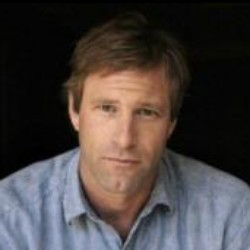

In [4]:
img = load_img(result[0])
print(type(img))
display(img)

In [5]:
# x_train = x_train[:1000]

def get_batch(size):
    
    arr = []
    
    for _ in range(size):
        
        k = rand.randint(0, 13233)
        arr.append(x_train[k])
    
    return np.array(arr)


In [6]:
# Generator

input_shape = (1, 1, 100)

generator = Sequential()

# conv2dTranspose layers to upsample
# generator.add(Conv2DTranspose(64,(5,5),strides=(2,2),activation='relu',input_shape=input_shape)) 
# generator.add(BatchNormalization())

# generator.add(Conv2DTranspose(128,(5,5),strides=(2,2),activation='relu',input_shape=input_shape)) 
# generator.add(BatchNormalization())

# generator.add(Conv2DTranspose(256,(5,5),strides=(2,2),activation='relu',input_shape=input_shape)) 
# generator.add(BatchNormalization())

# generator.add(Conv2DTranspose(3,(5,5),strides=(2,2),activation='relu',input_shape=input_shape))
# generator.add(BatchNormalization())

# --------------------------------------------------------------------------------------------------

generator.add(UpSampling2D(size=(5, 5), input_shape=input_shape)) # 100 x 5 x 5
generator.add(Conv2D(64,(2,2),activation='relu',padding='same')) # 64 x 5 x 5
# try adding strides=(2, 2)

generator.add(UpSampling2D(5)) # 64 x 25 x 25
generator.add(Conv2D(128,(2,2),activation='relu',padding='same')) # 128 x 25 x 25

generator.add(UpSampling2D(5)) # 128 x 125 x 125
generator.add(Conv2D(256,(2,2),activation='relu',padding='same')) # 256 x 125 x 125

generator.add(UpSampling2D(2)) # 256 x 250 x 250
generator.add(Conv2D(3,(2,2),activation='tanh',padding='same')) # 3 x 250 x 250

# --------------------------------------------------------------------------------------------------



# goal = 3 x 250 x 250

# Discriminator

img_shape = (250, 250, 3)

discriminator = Sequential()

# --------------------------------------------------------------------------------------------------

# discriminator.add(Conv2D(64,(10,10),activation='relu',input_shape=img_shape)) # 64x241x241 --> 64x120x120
# discriminator.add(MaxPooling2D())
# # try changing MaxPooling2D to AveragePooling2D

# discriminator.add(Conv2D(128,(7,7),activation='relu', kernel_regularizer=l2(2e-4))) # 128x114x114 --> 128x57x57
# discriminator.add(MaxPooling2D())

# discriminator.add(Conv2D(256,(4,4),activation='relu',kernel_regularizer=l2(2e-4))) # 256x54x54 --> 256x27x27 
# discriminator.add(MaxPooling2D())

# discriminator.add(Conv2D(512,(7,7),activation='relu',kernel_regularizer=l2(2e-4))) # 512x21x21 --> 512x10x10
# discriminator.add(MaxPooling2D())

# discriminator.add(Conv2D(1024,(10,10),activation='relu')) # 1024x1x1

# --------------------------------------------------------------------------------------------------

# discriminator.add(Conv2D(64,(3,3),activation='relu',input_shape=img_shape)) # 64x241x241 --> 64x120x120
# discriminator.add(MaxPooling2D())
# # try changing MaxPooling2D to AveragePooling2D

# discriminator.add(Conv2D(128,(4,4),activation='relu', kernel_regularizer=l2(2e-4))) # 128x114x114 --> 128x57x57
# discriminator.add(MaxPooling2D())

# discriminator.add(Conv2D(256,(5,5),activation='relu',kernel_regularizer=l2(2e-4))) # 256x54x54 --> 256x27x27 
# discriminator.add(MaxPooling2D())

# discriminator.add(Conv2D(512,(4,4),activation='relu',kernel_regularizer=l2(2e-4))) # 512x21x21 --> 512x10x10
# discriminator.add(MaxPooling2D())

# discriminator.add(Conv2D(1024,(3,3),activation='relu')) # 1024x1x1

# --------------------------------------------------------------------------------------------------

discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))

# --------------------------------------------------------------------------------------------------

discriminator.add(Flatten()) # (None, 1024)

discriminator.add(Dense(1,activation="sigmoid",kernel_regularizer=l2(1e-3))) # (None, 1)

In [7]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d_1 (UpSampling2 (None, 5, 5, 100)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 64)          25664     
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 128)       32896     
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 125, 125, 128)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 125, 125, 256)     131328    
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 250, 250, 256)     0         
__________

In [8]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 125, 125, 32)      896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 125, 125, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 64)        0         
__________

In [9]:
# GAN

# initially -- since we only want to train either the generator or discriminator at a time
# discriminator.trainable = False

# gan input (noise) will be 100-dimensional vectors
gan_input = Input(shape=input_shape)

gan = Model(inputs = gan_input, outputs = discriminator(generator(gan_input)) )

gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.00002, beta_1=0.5))

discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.00002, beta_1=0.5))



--------------- Epoch: 0 ---------------


/home/arjung2/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Discriminator loss: 0.035642613, GAN loss: 1.2166797

Discriminator loss: 0.03392298, GAN loss: 0.45541918

Discriminator loss: 0.019035103, GAN loss: 0.1024999

Discriminator loss: 0.009792598, GAN loss: 0.14129506

Discriminator loss: 0.005328912, GAN loss: 0.026163893

Discriminator loss: 0.006790503, GAN loss: 0.013456942

Discriminator loss: 0.004283012, GAN loss: 0.013959711

Discriminator loss: 0.0039672186, GAN loss: 0.014890274

Discriminator loss: 0.0032609466, GAN loss: 0.010362806

Loss History:


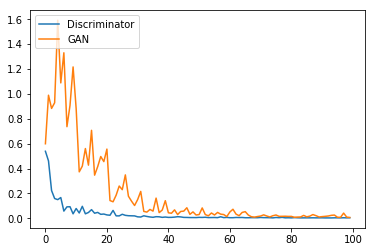

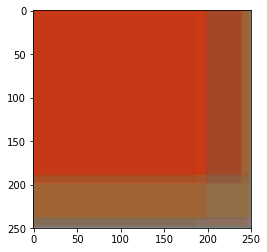

[0.99986696]


--------------- Epoch: 1 ---------------
Discriminator loss: 0.003256233, GAN loss: 0.014671839

Discriminator loss: 0.002773054, GAN loss: 0.01690447

Discriminator loss: 0.0033482867, GAN loss: 0.011863752

Discriminator loss: 0.0028027396, GAN loss: 0.004777386

Discriminator loss: 0.0023948262, GAN loss: 0.0061351033

Discriminator loss: 0.0024734435, GAN loss: 0.012148239

Discriminator loss: 0.00235781, GAN loss: 0.003343008

Discriminator loss: 0.002472639, GAN loss: 0.0034754553

Discriminator loss: 0.0022646994, GAN loss: 0.0044348678

Loss History:


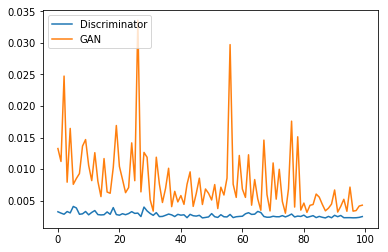

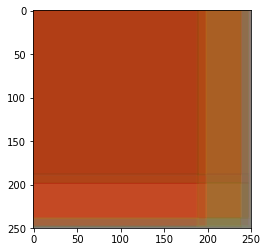

[0.9999063]


--------------- Epoch: 2 ---------------
Discriminator loss: 0.0023598126, GAN loss: 0.004916941

Discriminator loss: 0.0026036068, GAN loss: 0.0031915868

Discriminator loss: 0.0022639972, GAN loss: 0.0025100098

Discriminator loss: 0.002210459, GAN loss: 0.003227241

Discriminator loss: 0.002313864, GAN loss: 0.0077447947

Discriminator loss: 0.0021504664, GAN loss: 0.0024330092

Discriminator loss: 0.002155087, GAN loss: 0.0032577994

Discriminator loss: 0.0021275992, GAN loss: 0.0039898898

Discriminator loss: 0.0021543186, GAN loss: 0.0024736947

Loss History:


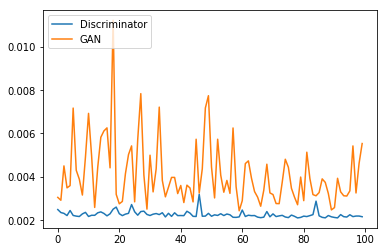

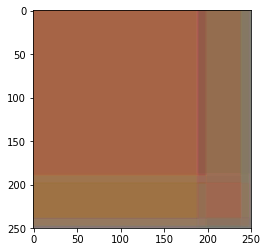

[1.]


--------------- Epoch: 3 ---------------
Discriminator loss: 0.0021344707, GAN loss: 0.0027302857

Discriminator loss: 0.0022596177, GAN loss: 0.00264591

Discriminator loss: 0.0021220953, GAN loss: 0.0027901055

Discriminator loss: 0.0024263628, GAN loss: 0.0025779228

Discriminator loss: 0.0021327012, GAN loss: 0.0036968794

Discriminator loss: 0.0021195314, GAN loss: 0.0027885581

Discriminator loss: 0.0021859955, GAN loss: 0.0029203517

Discriminator loss: 0.002062793, GAN loss: 0.0024282176

Discriminator loss: 0.0021215274, GAN loss: 0.002594728

Loss History:


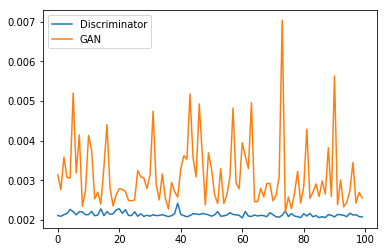

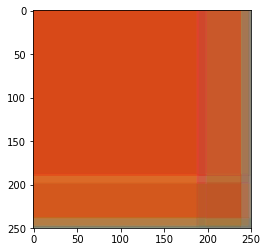

[0.9999931]


--------------- Epoch: 4 ---------------
Discriminator loss: 0.002072233, GAN loss: 0.0043521174

Discriminator loss: 0.0020711755, GAN loss: 0.0022963781

Discriminator loss: 0.0021065008, GAN loss: 0.002351237

Discriminator loss: 0.0020587656, GAN loss: 0.0023555858

Discriminator loss: 0.0020804084, GAN loss: 0.00238367

Discriminator loss: 0.0020935363, GAN loss: 0.0027089003

Discriminator loss: 0.0020828482, GAN loss: 0.004919295

Discriminator loss: 0.0020681801, GAN loss: 0.0023362653

Discriminator loss: 0.0021135719, GAN loss: 0.0021255475

Loss History:


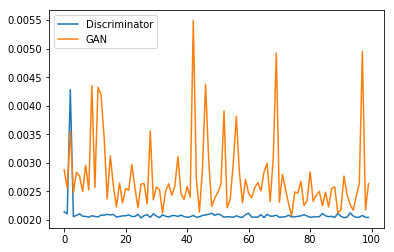

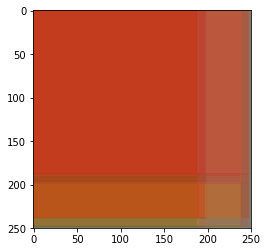

[0.9999887]


--------------- Epoch: 5 ---------------
Discriminator loss: 0.0020335324, GAN loss: 0.002394472

Discriminator loss: 0.0020493006, GAN loss: 0.0025247582

Discriminator loss: 0.002060548, GAN loss: 0.0022520428

Discriminator loss: 0.0020346206, GAN loss: 0.0022609099

Discriminator loss: 0.0020457583, GAN loss: 0.0024861204

Discriminator loss: 0.002052679, GAN loss: 0.0030750358

Discriminator loss: 0.0020507728, GAN loss: 0.002238717

Discriminator loss: 0.0020345838, GAN loss: 0.0023772244

Discriminator loss: 0.0020547428, GAN loss: 0.0021845894

Loss History:


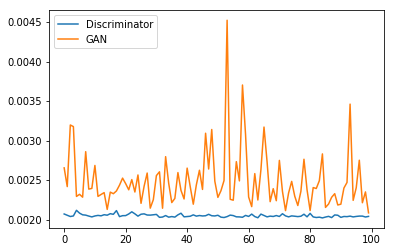

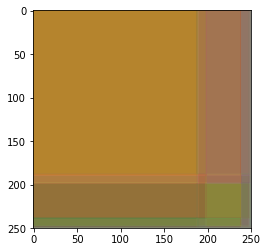

[1.]


--------------- Epoch: 6 ---------------
Discriminator loss: 0.0020348132, GAN loss: 0.0031292753

Discriminator loss: 0.002056232, GAN loss: 0.0021757449

Discriminator loss: 0.0020191753, GAN loss: 0.0022554477

Discriminator loss: 0.002021253, GAN loss: 0.0023858845

Discriminator loss: 0.0020490603, GAN loss: 0.0022180027

Discriminator loss: 0.0020318253, GAN loss: 0.0024512932

Discriminator loss: 0.0020258243, GAN loss: 0.0024324008

Discriminator loss: 0.0020551253, GAN loss: 0.00291085

Discriminator loss: 0.002016321, GAN loss: 0.0022805524

Loss History:


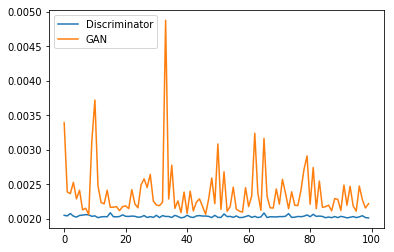

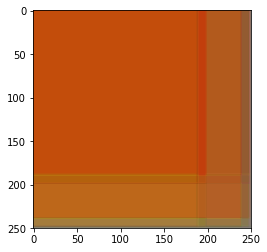

[0.99993455]


--------------- Epoch: 7 ---------------
Discriminator loss: 0.0020302385, GAN loss: 0.0023288107

Discriminator loss: 0.0020124395, GAN loss: 0.002217097

Discriminator loss: 0.0020082456, GAN loss: 0.002159584

Discriminator loss: 0.0020050562, GAN loss: 0.0021948568

Discriminator loss: 0.0020156566, GAN loss: 0.0022139428

Discriminator loss: 0.0020143983, GAN loss: 0.0021919855

Discriminator loss: 0.0020024327, GAN loss: 0.002081299

Discriminator loss: 0.0020154463, GAN loss: 0.0023258692

Discriminator loss: 0.0020198133, GAN loss: 0.002200049

Loss History:


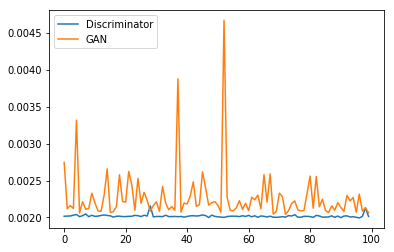

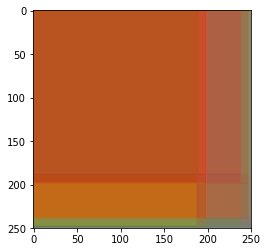

[0.9999989]


--------------- Epoch: 8 ---------------
Discriminator loss: 0.0020019077, GAN loss: 0.002177519

Discriminator loss: 0.0020307961, GAN loss: 0.0024735276

Discriminator loss: 0.001994417, GAN loss: 0.0021975243

Discriminator loss: 0.0020024127, GAN loss: 0.0022840437

Discriminator loss: 0.0019974168, GAN loss: 0.0023097075

Discriminator loss: 0.0019993726, GAN loss: 0.0021707104

Discriminator loss: 0.0019934922, GAN loss: 0.0021534318

Discriminator loss: 0.0020047382, GAN loss: 0.0022647178

Discriminator loss: 0.001998261, GAN loss: 0.0020289894

Loss History:


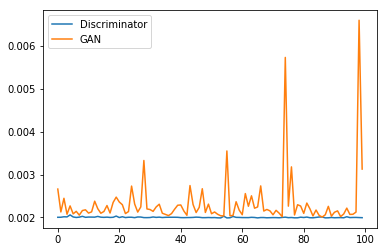

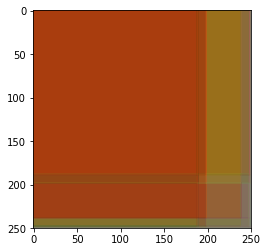

[0.9998909]


--------------- Epoch: 9 ---------------
Discriminator loss: 0.001992041, GAN loss: 0.0021984603

Discriminator loss: 0.001992537, GAN loss: 0.002319915

Discriminator loss: 0.0019916873, GAN loss: 0.0020646793

Discriminator loss: 0.0019855376, GAN loss: 0.0021842008

Discriminator loss: 0.0020155774, GAN loss: 0.0020831411

Discriminator loss: 0.0019871262, GAN loss: 0.0020993226

Discriminator loss: 0.0019844905, GAN loss: 0.0020459176

Discriminator loss: 0.0019829937, GAN loss: 0.002255635

Discriminator loss: 0.0019845017, GAN loss: 0.0020164226

Loss History:


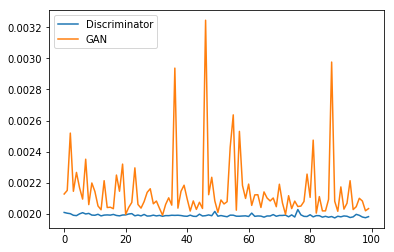

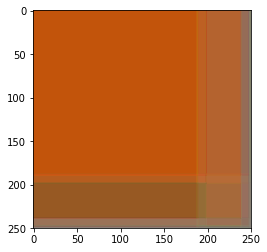

[0.9999924]


In [10]:
epochs = 10
batch_size = 10

for i in range(epochs):
    
    print("\n")
    print('-'*15, 'Epoch: ' + str(i), '-'*15)
    
    x_train_batch = get_batch(1000)
    # Number of batches
    batch_count = x_train_batch.shape[0] / batch_size
    
    start = 0
    end = batch_size
    
    d_loss = 0
    g_loss = 0
    g_loss_arr = []
    d_loss_arr = []
        
    for j in range(int(batch_count)):
        
        if j % 10 == 0 and j != 0:
            # print(".", end="")
            print("Discriminator loss: " + str(d_loss) + ", GAN loss: " + str(g_loss) + "\n")
        
        # Get a random set of input noise and images
        # generator.trainable = False
        noise = np.random.normal(0, 1, size=[batch_size, 1, 1, 100])        
        image_batch = x_train_batch[start:end]
        image_batch = np.reshape(image_batch, (batch_size, 250, 250, 3))
        
        # Generate fake images
        generated_images = generator.predict(noise)
        X = np.concatenate([image_batch, generated_images])

        # Labels for generated and real data
        y_dis = np.zeros(2*batch_size)
        y_dis[:batch_size] = 1

        # Train discriminator
        discriminator.trainable = True
        # discriminator.fit(X, y_dis, epochs=10)
        d_loss = discriminator.train_on_batch(X, y_dis)
        d_loss = discriminator.train_on_batch(X, y_dis)
        
        # d_history = discriminator.fit(X, y_dis)
        d_loss_arr.append(d_loss)

        # Train generator
        noise = np.random.normal(0, 1, size=[batch_size, 1, 1, 100])
        # The y-label will be 1 since we want to train the generator such that the GAN gives out 1
        y_gen = np.ones(batch_size)
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gen)
        # g_loss = gan.train_on_batch(noise, y_gen)
        # g_history = gan.fit(noise, y_gen)
        g_loss_arr.append(g_loss)
        
        # Update start and end
        start += batch_size
        end += batch_size

    print("Loss History:")
    plt.plot(d_loss_arr, label = 'Discriminator')
    plt.plot(g_loss_arr, label = 'GAN')
    plt.legend(loc='upper left')
    plt.show()
    
    # Display a sample of the results
    examples = 1
    noise = np.random.normal(0, 1, size=[examples, 1, 1, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images * 0.5 + 0.5

    arr = discriminator.predict(generated_images)
    generated_images = generated_images.reshape(examples, 250, 250, 3)
    generated_images = np.clip(generated_images, 0, 1)

    for k in range(examples):
        # plt.imshow(generated_images[k], interpolation='nearest', cmap='gray_r')
        # plt.imshow(generated_images[k], interpolation='nearest')
        plt.imshow(generated_images[k], vmin=0, vmax=1)
        plt.show()
        print(arr[k])

In [11]:
# # Display a sample of the results
# examples = 5
# noise = np.random.normal(0, 1, size=[examples, 1, 1, 100])
# generated_images = generator.predict(noise)
# generated_images = generated_images * 0.5 + 0.5
# plt.show()
# print(generated_images.shape)
# print(np.max(generated_images))
# arr = discriminator.predict(generated_images)
# generated_images = generated_images.reshape(examples, 250, 250, 3)
# generated_images = np.clip(generated_images, 0, 1)

# for k in range(examples):
#     # plt.imshow(generated_images[k], interpolation='nearest', cmap='gray_r')
#     # plt.imshow(generated_images[k], interpolation='nearest')
#     plt.imshow(generated_images[k], vmin=0, vmax=1)
#     plt.show()
#     print(arr[k])